In [80]:
import requests
import pandas as pd

url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&outputsize=full&apikey=8K9M3ISUT9ESEBD6"
api_data = requests.get(url).json()
api_data

apple_df=pd.DataFrame(api_data['Time Series (Daily)']).T


In [81]:
#apple_df['4. close'].head()

In [82]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [121]:
data = apple_df
data['Date']=data.index
data=data.rename(columns={'1. open':'Open'})
data.head()

,Open,2. high,3. low,4. close,5. volume,Date
2024-06-03,166.5400,166.7800,163.5300,165.2800,2776058,2024-06-03
2024-05-31,165.7000,166.9700,163.8400,166.8500,4905002,2024-05-31
2024-05-30,165.5600,166.7300,164.2300,165.6300,3852963,2024-05-30
2024-05-29,168.0000,168.6300,166.2100,167.0500,4206576,2024-05-29
2024-05-28,170.4400,171.0850,168.6500,169.6600,2629645,2024-05-28


In [122]:
cols = data.columns.tolist()
cols
cols = cols[-1:] + cols[:-1]
cols
data=data[cols]
data.head()

,Date,Open,2. high,3. low,4. close,5. volume
2024-06-03,2024-06-03,166.5400,166.7800,163.5300,165.2800,2776058
2024-05-31,2024-05-31,165.7000,166.9700,163.8400,166.8500,4905002
2024-05-30,2024-05-30,165.5600,166.7300,164.2300,165.6300,3852963
2024-05-29,2024-05-29,168.0000,168.6300,166.2100,167.0500,4206576
2024-05-28,2024-05-28,170.4400,171.0850,168.6500,169.6600,2629645


In [85]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 6186
Train data length : 4330
Validation data lenth : 1856


In [86]:
train_data = data[:length_train].iloc[:,:2]
train_data.head()

,Date,1. open
2024-06-03,2024-06-03,166.5400
2024-05-31,2024-05-31,165.7000
2024-05-30,2024-05-30,165.5600
2024-05-29,2024-05-29,168.0000
2024-05-28,2024-05-28,170.4400


In [117]:
train_data = data[:length_train].iloc[:,:2]
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data['Date']=train_data['Date'].astype('datetime64[ns]')

In [116]:
validation_data = data[length_train:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])# converting to date time
validation_data['Date']=validation_data['Date'].astype('datetime64[ns]')

In [89]:
dataset_train = train_data['1. open'].values
dataset_train.shape

(4330,)

In [90]:
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(4330, 1)

In [91]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(4330, 1)

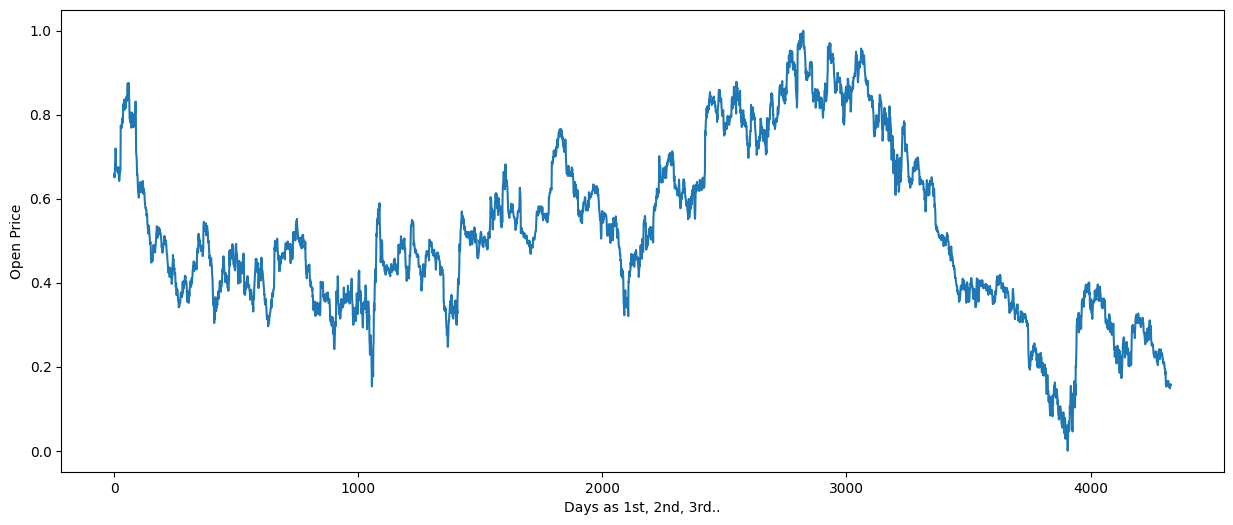

In [92]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price")
plt.show()

In [93]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])

# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

In [94]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (4280, 50)
Shape of y_train before reshape : (4280,)


In [95]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (4280, 50, 1)
Shape of y_train after reshape : (4280, 1)


In [96]:
X_train[0]

array([[0.65759955],
       [0.6517106 ],
       [0.65072911],
       [0.66783511],
       [0.68494111],
       [0.69223219],
       [0.71964386],
       [0.70562255],
       [0.68143578],
       [0.67484577],
       [0.67463545],
       [0.66965788],
       [0.66741447],
       [0.66685362],
       [0.66432978],
       [0.66173584],
       [0.66432978],
       [0.66790522],
       [0.67484577],
       [0.65731913],
       [0.64680314],
       [0.64224621],
       [0.65164049],
       [0.65724902],
       [0.66362872],
       [0.66432978],
       [0.66923724],
       [0.77418676],
       [0.77110208],
       [0.76913909],
       [0.76899888],
       [0.76843803],
       [0.78112731],
       [0.79115255],
       [0.79101234],
       [0.78000561],
       [0.79430735],
       [0.80398205],
       [0.8258553 ],
       [0.81674145],
       [0.81218452],
       [0.83609086],
       [0.81225463],
       [0.81604038],
       [0.82206955],
       [0.82865956],
       [0.81926528],
       [0.815

In [97]:
y_train[0]

array([0.84310151])

In [98]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True,
              input_shape = (X_train.shape[1],1))
             )

regressor.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50,
              activation = "tanh",
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50)
             )

regressor.add(
    Dropout(0.2)
             )

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam",
    loss = "mean_squared_error",
    metrics = ["accuracy"])

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 1.9844e-04 - loss: 0.3574
Epoch 2/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.0011 - loss: 0.1163
Epoch 3/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 3.0504e-04 - loss: 0.0633
Epoch 4/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 6.2222e-04 - loss: 0.0363
Epoch 5/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 4.2565e-04 - loss: 0.0215
Epoch 6/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 2.3562e-04 - loss: 0.0154
Epoch 7/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 1.7150e-04 - loss: 0.0117
Epoch 8/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 2.5191e-04 - loss: 0.0099
Epoch 9/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 3.7153e-04 - loss: 0.0081
Epoch 10/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 5.6605e-05 - loss: 0.0069
Epoch 11/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 8.0858e-04 - loss: 0.0059


In [99]:
history.history["loss"]

[0.2543250024318695,
 0.09623344987630844,
 0.053889721632003784,
 0.03146589547395706,
 0.02053036354482174,
 0.014898225665092468,
 0.011430369690060616,
 0.009313284419476986,
 0.007524654269218445,
 0.006679154001176357,
 0.00572036812081933,
 0.004967649467289448,
 0.0046030986122787,
 0.0040030344389379025,
 0.003754108212888241,
 0.003366517834365368,
 0.003340192139148712,
 0.0030277601908892393,
 0.0026991060003638268,
 0.0027035262901335955,
 0.0026692955289036036,
 0.0023951877374202013,
 0.002440579002723098,
 0.0022476238664239645,
 0.002230907091870904]

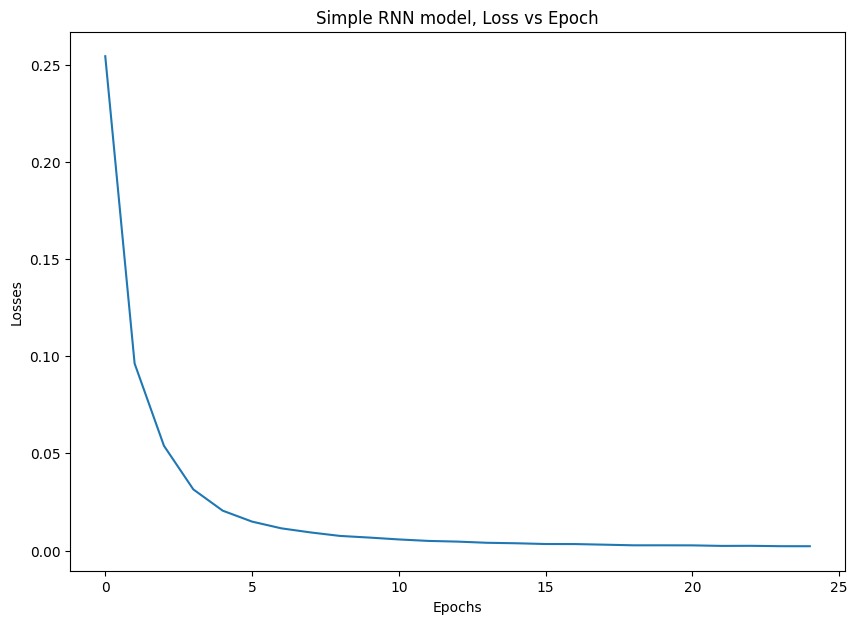

In [100]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

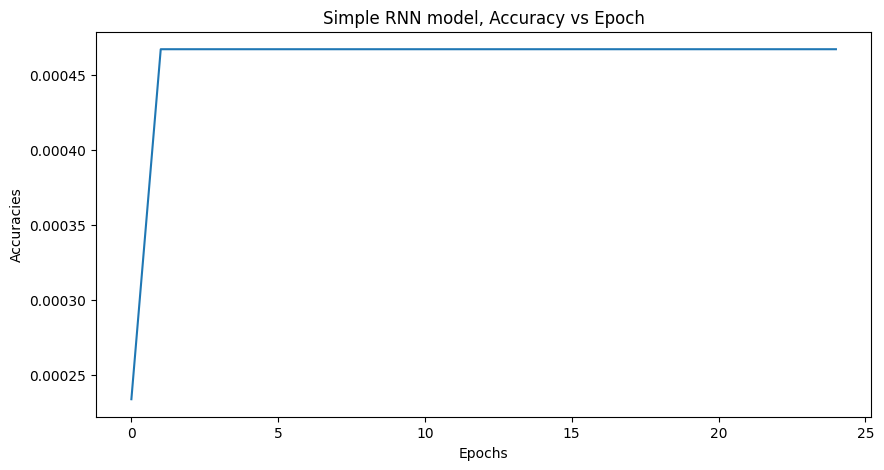

In [101]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

In [102]:
y_pred = regressor.predict(X_train)  # predictions
y_pred = scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

134/134 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


(4280, 1)

In [103]:
y_train = scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(4280, 1)

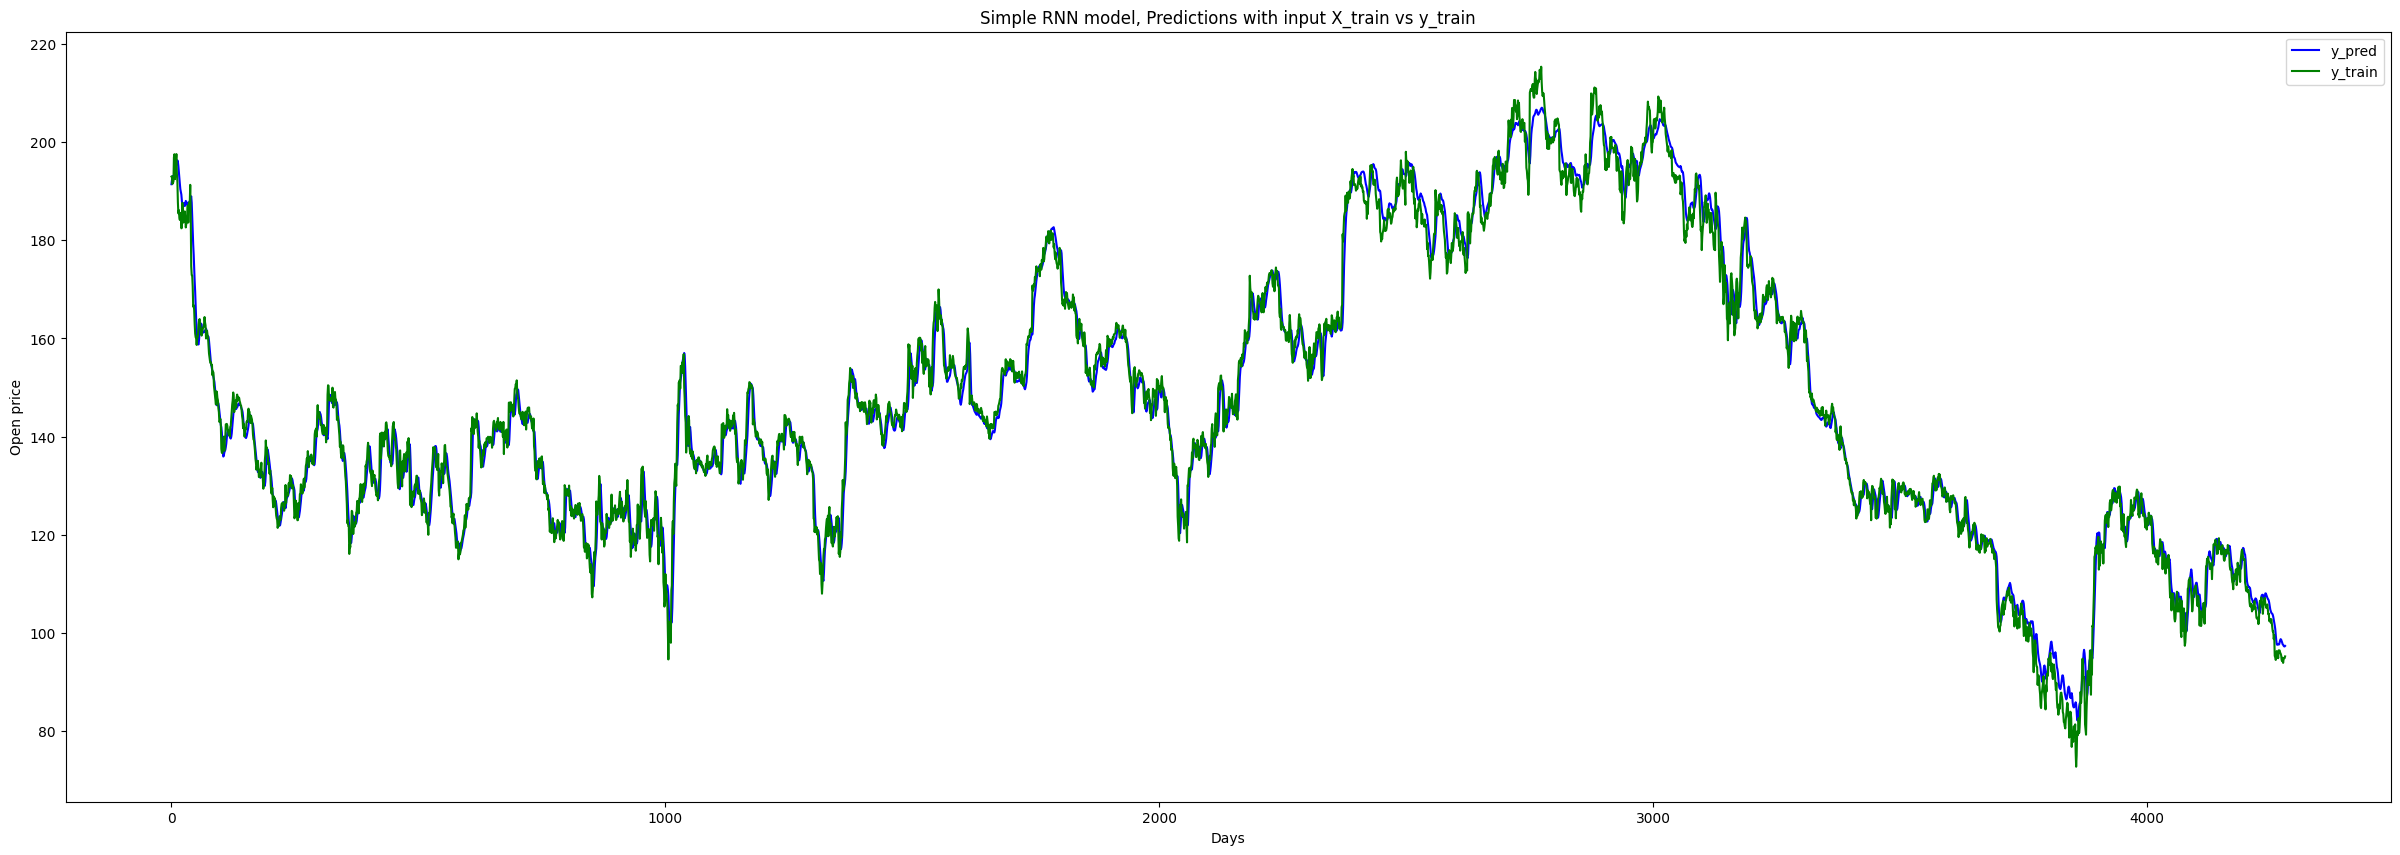

In [104]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()

In [105]:
#Creating Test Set from Validation Set

dataset_validation = validation_data['1. open'].values  # getting "open" column and converting to array
dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

Shape of scaled validation dataset : (1856, 1)


In [106]:
X_test = []
y_test = []

for i in range(time_step, length_validation):
    X_test.append(scaled_dataset_validation[i-time_step:i,0])
    y_test.append(scaled_dataset_validation[i,0])

In [107]:
X_test, y_test = np.array(X_test), np.array(y_test)

In [108]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

Shape of X_test before reshape : (1806, 50)
Shape of y_test before reshape : (1806,)


In [109]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

In [110]:
print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

Shape of X_test after reshape : (1806, 50, 1)
Shape of y_test after reshape : (1806, 1)


In [111]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test)
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Shape of y_pred_of_test : (1806, 1)


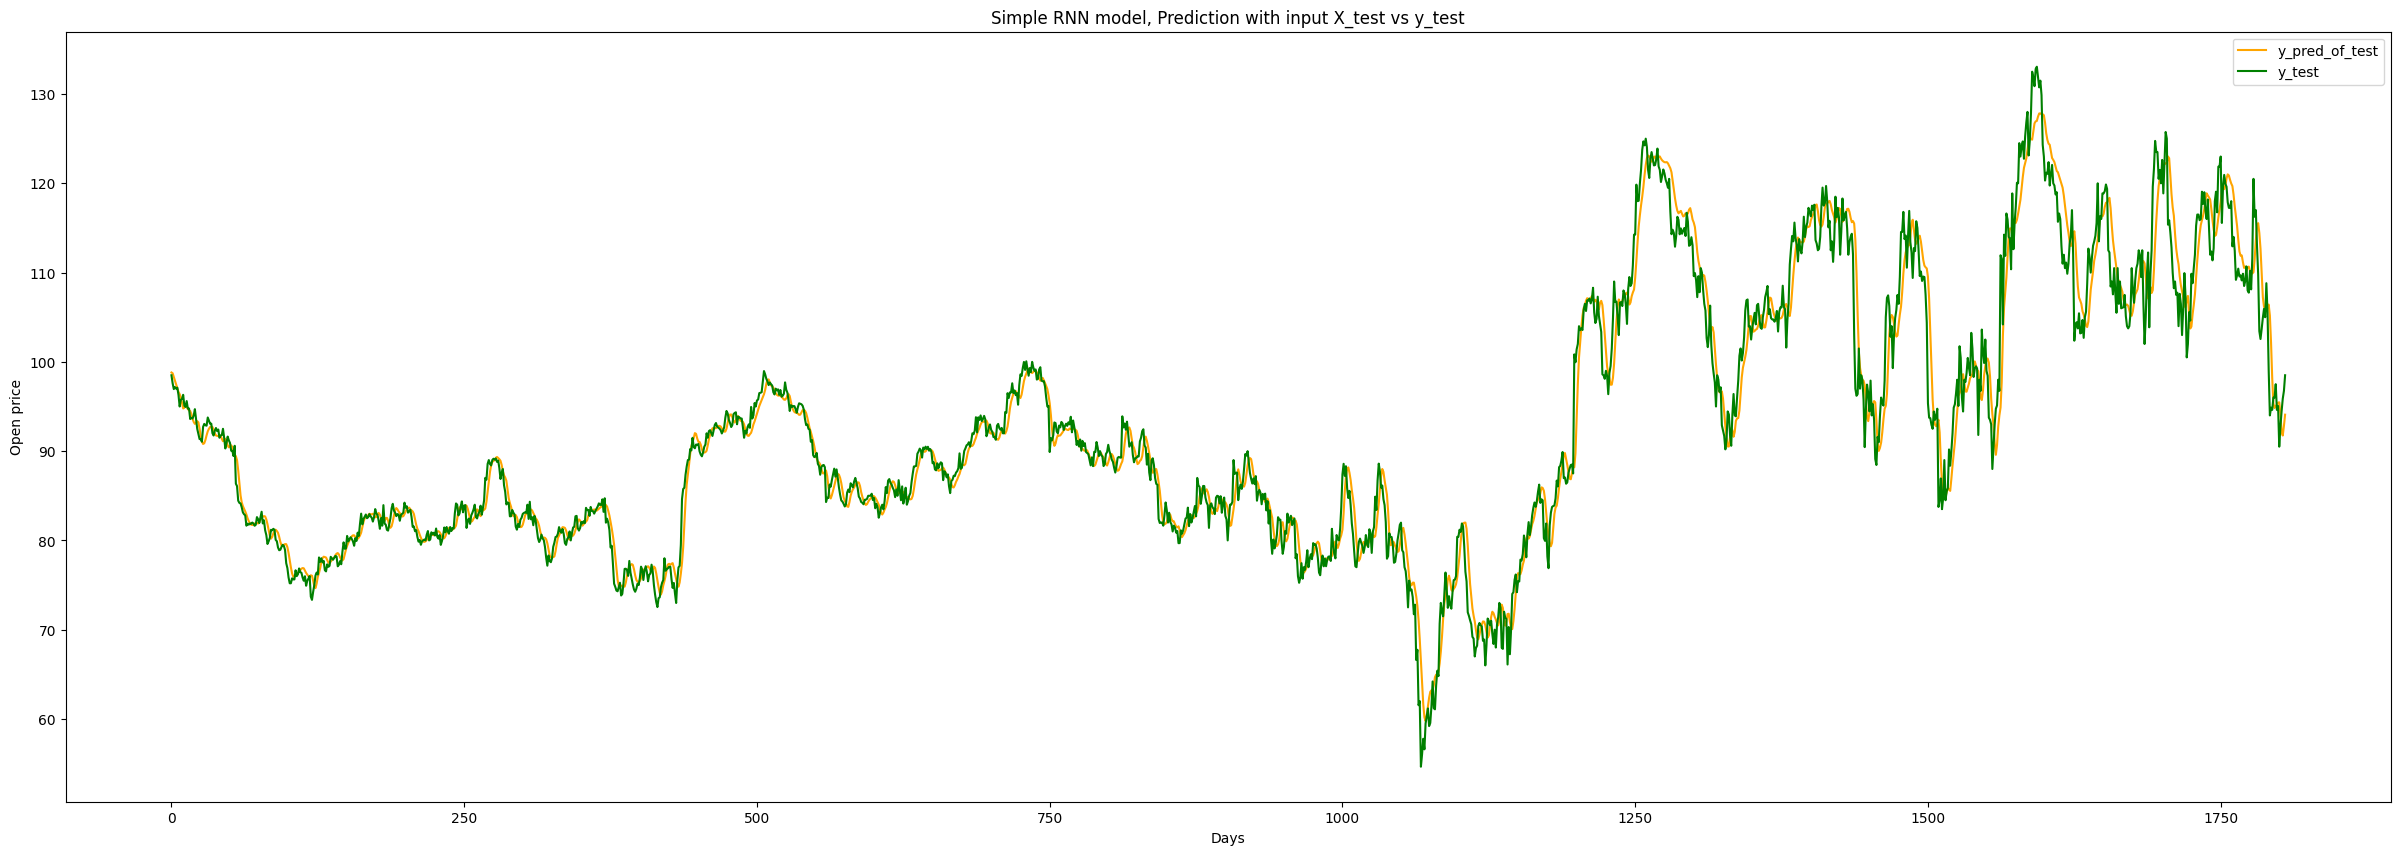

In [112]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

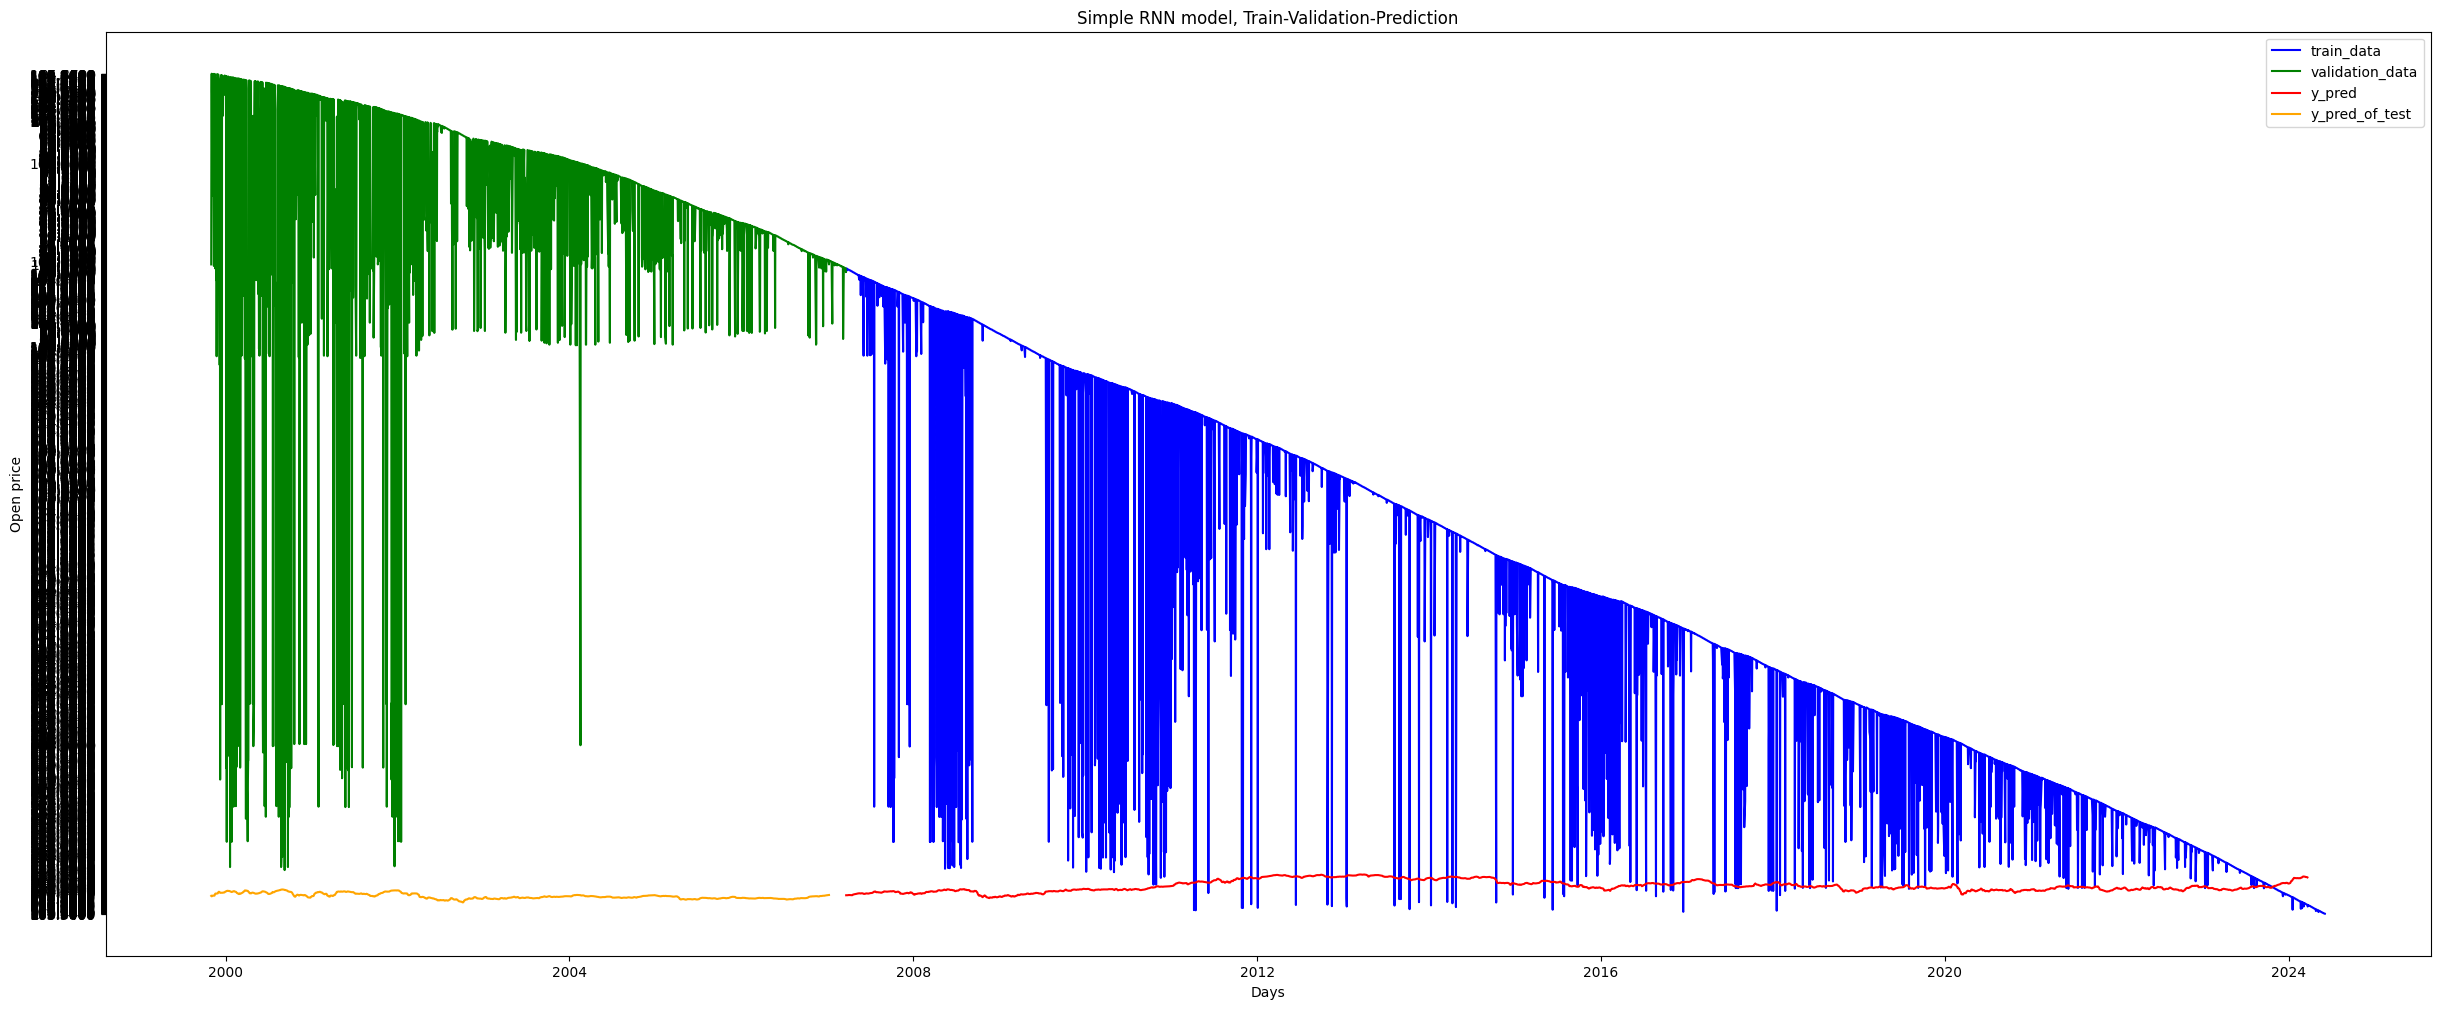

In [119]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.Date, train_data['1. open'], label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data['1. open'], label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()